# 0.02 Generate Climatology S2S

---

This notebook takes in the `.zarr` raw S2S array we made in `0.01_concatenate_S2S` and generates a daily climatology (with band pass filtering) to remove from the raw S2S output to create anomalies.

In [1]:
#%load_ext lab_black

import numpy as np
import xarray as xr
import dask.array as da

from dask.distributed import Client

In [2]:
client = Client("tcp://10.12.205.200:43738")

First, we need to calculate the daily climatology following the SubX protocol. We'll load in our big `zarr`, take the ensemble mean, and then generate the climatology.

In [3]:
#ds = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/CESM1.S2S.zg_500.raw.zarr", consolidated=True)
#ds = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/CESM2.S2S.tas_2m.raw.zarr",consolidated=True)
ds = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/WACCM.S2S.tas_2m.raw.zarr", consolidated=True)
display(ds)

,Array,Chunk
Bytes,39.27 GB,59.95 MB
Shape,"(655, 5, 46, 181, 360)","(1, 5, 46, 181, 360)"
Count,656 Tasks,655 Chunks
Type,float32,numpy.ndarray


Here I "persist" the ensemble mean. This essentially runs the calculation in the background, but maintains the result as dask arrays distributed across the cluster, rather than loading it into RAM memory on the main node.

In [4]:
ds = ds.mean("member").persist()

In [5]:
display(ds.TAS)

,Array,Chunk
Bytes,7.85 GB,11.99 MB
Shape,"(655, 46, 181, 360)","(1, 46, 181, 360)"
Count,655 Tasks,655 Chunks
Type,float32,numpy.ndarray


## Generate Climatology

We'll be taking an average over the `dayofyear` of the `init` dimension, so it's best to rechunk so that `init` is a single chunk. That will speed things up. I'll make `lead` chunks of 1 since we are doing a lead-dependent climatology.

I usually run `.persist()` after re-chunking so that it can re-load it's chunks properly.

In [6]:
ds = ds.chunk({"init": -1, "lead": 1, "lat": "auto", "lon": "auto"}).persist()

In [7]:
ds.TAS.init

<xarray.DataArray 'init' (init: 655)>
array([cftime.DatetimeNoLeap(1999, 2, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2010, 2, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2016, 2, 1, 0, 0, 0, 0), ...,
       cftime.DatetimeNoLeap(2005, 10, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2011, 10, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2016, 10, 31, 0, 0, 0, 0)], dtype=object)
Coordinates:
  * init     (init) object 1999-02-01 00:00:00 ... 2016-10-31 00:00:00

All of the following is from Ray Bell's climatology script for SubX that Kathy uses. Direct questions to them about the methodology! This uses a smoothed window approach to smooth out the daily climatology for initializations.

In [8]:
ds.TAS.groupby("init.dayofyear").mean("init")

,Array,Chunk
Bytes,2.53 GB,130.32 kB
Shape,"(211, 46, 181, 360)","(1, 1, 181, 180)"
Count,77740 Tasks,19412 Chunks
Type,float32,numpy.ndarray


In [9]:
# Groupby is notoriously slow with `dask`. There are some ways around it but we'll
# keep it simple here.
da_day_clim = ds.TAS.groupby("init.dayofyear").mean("init")

In [10]:
# Rechunk to make dayofyear climatology one chunk.
#da_day_clim = da_day_clim.chunk({"dayofyear": 365}).persist()
da_day_clim = da_day_clim.chunk({"dayofyear": 211}).persist() #for WACCM

In [11]:
# Just mimicking the chunk sizes from our climatology.
#x = da.full((365, da_day_clim.lead.size, da_day_clim.lat.size, da_day_clim.lon.size),
#    np.nan,dtype="float32",chunks=(365, 1, 181, 180),)
x = da.full((211, da_day_clim.lead.size, da_day_clim.lat.size, da_day_clim.lon.size),
    np.nan,dtype="float32",chunks=(211, 1, 181, 180),) # for WACCM 211 days

In [37]:
_da = xr.DataArray(x,dims=["dayofyear", "lead", "lat", "lon"],
    coords=[da_day_clim.dayofyear, da_day_clim.lead, da_day_clim.lat, da_day_clim.lon],name="TAS",)

In [38]:
# Pad the daily climatolgy with nans
# RXB: Not sure that this is needed, but just following Ray's methods.
da_day_clim_wnan = da_day_clim.combine_first(_da)

In [39]:
# Period rolling twice to make it triangular smoothing
# See https://bit.ly/2H3o0Mf
da_day_clim_smooth = da_day_clim_wnan.copy()

In [40]:
for i in range(2):
    # Extand the DataArray to allow rolling to do periodic
    da_day_clim_smooth = xr.concat([da_day_clim_smooth[-15:], da_day_clim_smooth, da_day_clim_smooth[:15]],"dayofyear",)
    # Rolling mean
    da_day_clim_smooth = da_day_clim_smooth.rolling(dayofyear=31, center=True, min_periods=1).mean()
    # Drop the periodic boundaries
    da_day_clim_smooth = da_day_clim_smooth.isel(dayofyear=slice(15, -15))

In [41]:
# Extract the original days
da_day_clim_smooth = da_day_clim_smooth.sel(dayofyear=da_day_clim.dayofyear)
da_day_clim_smooth.name = "TAS"

Save out the daily climatology for the S2S run. This is a lead-dependent daily climatology at each grid cell. We'll use it to subtract out the climatology from the raw run.

In [42]:
display(da_day_clim_smooth)

,Array,Chunk
Bytes,2.53 GB,27.50 MB
Shape,"(211, 46, 181, 360)","(211, 1, 181, 180)"
Count,16836 Tasks,92 Chunks
Type,float32,numpy.ndarray


Great, now we've saved out the lead-dependent daily climatology.

In [43]:
#%time da_day_clim_smooth.to_dataset().to_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/CESM2.S2S.tas_2m.climatology.zarr", consolidated=True)
%time da_day_clim_smooth.to_dataset().to_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/WACCM.S2S.tas_2m.climatology.zarr", consolidated=True)

CPU times: user 2.01 s, sys: 44.1 ms, total: 2.06 s
Wall time: 15.3 s


Just a quick check that things look right.

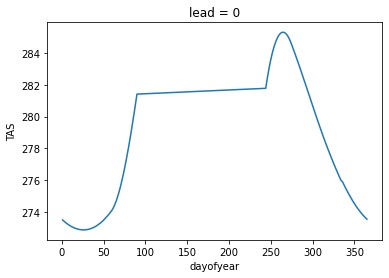

In [44]:
da_day_clim_smooth.isel(lead=0,lat=slice(91,180)).mean(("lat","lon")).plot()
#da_day_clim_smooth.isel(lead=0).mean(("lat","lon")).plot()

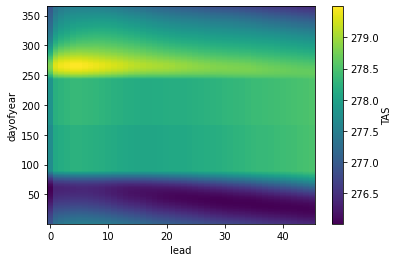

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [45]:
da_day_clim_smooth.mean(("lat", "lon")).plot()